In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter
import warnings
import sys

/var/folders/g1/pdsb5q1j5k1fd8sr26nv9pqh0000gn/T/ipykernel_58029/2810584121.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.0)
  from scipy.signal import savgol_filter


In [2]:
warnings.filterwarnings('ignore')

In [3]:
try:
    from pytransit import QuadraticModel
    PYTRANSIT_AVAILABLE = True
except ImportError:
    PYTRANSIT_AVAILABLE = False
    warnings.warn("pytransit not available. Using simplified transit model.")

In [4]:
try:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve, auc, RocCurveDisplay
    from sklearn.model_selection import train_test_split
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    warnings.warn("scikit-learn not available. Model training disabled.")

In [5]:
class TransitModel:
    """Fallback transit model if pytransit is not available"""
    @staticmethod
    def simple_transit_model(t, t0, duration, depth):
        """Simplified box-shaped transit model"""
        in_transit = (t >= t0 - duration/2) & (t <= t0 + duration/2)
        flux = np.ones_like(t)
        flux[in_transit] = 1 - depth
        return flux

In [6]:
class TransitDataGenerator:
    """Generates synthetic transit light curves"""
    def __init__(self):
        self.model = QuadraticModel() if PYTRANSIT_AVAILABLE else TransitModel()
        
    def generate_light_curve(self, params, n_points=1000, noise_level=0.001):
        t = np.linspace(params['t0'] - params['duration']/2, 
                        params['t0'] + params['duration']/2, 
                        n_points)
        
        if PYTRANSIT_AVAILABLE:
            self.model.set_data(t)
            flux = self.model.evaluate(
                k=params['rp'], 
                ldc=params['u'],
                t0=params['t0'],
                p=params['period'],
                a=params['a'],
                i=90,
                e=params.get('e', 0),
                w=params.get('w', 90)
            )
        else:
            # Use simplified model if pytransit not available
            depth = params['rp']**2  # Approximation
            flux = self.model.simple_transit_model(
                t, params['t0'], params['duration'], depth
            )
        
        flux += np.random.normal(0, noise_level, len(flux))
        return t, flux
    
    def generate_dataset(self, n_samples=1000, positive_ratio=0.5):
        n_positive = int(n_samples * positive_ratio)
        n_negative = n_samples - n_positive
        
        X, y = [], []
        
        # Positive samples
        for _ in range(n_positive):
            params = {
                't0': 0.5,
                'period': np.random.uniform(5, 20),
                'a': np.random.uniform(5, 20),
                'rp': np.random.uniform(0.01, 0.1),
                'u': [np.random.uniform(0.1, 0.3), np.random.uniform(0.1, 0.3)],
                'duration': np.random.uniform(0.05, 0.2)
            }
            _, flux = self.generate_light_curve(params)
            X.append(flux)
            y.append(1)
        
        # Negative samples
        for _ in range(n_negative):
            flux = 1 + np.random.normal(0, 0.001, 1000)
            X.append(flux)
            y.append(0)
            
        return np.array(X), np.array(y)

In [7]:
class FITSProcessor:
    """Processes FITS files to extract light curves"""
    @staticmethod
    def process_fits(filepath):
        try:
            with fits.open(filepath) as hdul:
                data = hdul[0].data
                if data.ndim == 5 and data.shape[2:] == (1, 1, 4):
                    return np.mean(data[:, :, 0, 0, 0], axis=(0, 1))
                return np.mean(data, axis=(0, 1))
        except Exception as e:
            raise ValueError(f"Error processing FITS file: {str(e)}")
    
    @staticmethod
    def preprocess_light_curve(light_curve, window_length=51, polyorder=3):
        try:
            smoothed = savgol_filter(light_curve, window_length, polyorder)
            return smoothed / np.median(smoothed)
        except:
            # Fallback simple normalization if smoothing fails
            return light_curve / np.median(light_curve)

In [8]:
class TransitClassifier:
    """Classifier for detecting planetary transits"""
    def __init__(self):
        self.model = None
        if not SKLEARN_AVAILABLE:
            raise ImportError("scikit-learn is required for classification")
        
    def train(self, X_train, y_train):
        self.model = RandomForestClassifier(
            n_estimators=100, 
            random_state=42,
            n_jobs=-1  # Use all available cores
        )
        self.model.fit(X_train, y_train)
        
    def evaluate(self, X_test, y_test):
        y_proba = self.model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.title('ROC Curve')
        plt.show()
        
        return roc_auc
    
    def predict(self, X):
        return self.model.predict(X), self.model.predict_proba(X)[:, 1]

In [9]:
class ExoplanetPipeline:
    """End-to-end exoplanet detection pipeline"""
    def __init__(self):
        self.data_gen = TransitDataGenerator()
        self.fits_processor = FITSProcessor()
        if SKLEARN_AVAILABLE:
            self.classifier = TransitClassifier()
        else:
            self.classifier = None
    
    def run_training(self, synthetic_samples=5000, test_size=0.2):
        if not SKLEARN_AVAILABLE:
            raise RuntimeError("scikit-learn is required for training")
            
        X, y = self.data_gen.generate_dataset(n_samples=synthetic_samples)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        self.classifier.train(X_train, y_train)
        roc_auc = self.classifier.evaluate(X_test, y_test)
        print(f"Model trained with AUC: {roc_auc:.3f}")
    
    def predict_from_fits(self, filepath):
        if self.classifier is None:
            raise RuntimeError("Classifier not trained or scikit-learn not available")
            
        lc = self.fits_processor.process_fits(filepath)
        processed_lc = self.fits_processor.preprocess_light_curve(lc)
        pred, prob = self.classifier.predict(processed_lc.reshape(1, -1))
        
        print(f"Result: {'TRANSIT' if pred[0] else 'NO TRANSIT'} (confidence: {prob[0]:.2%})")
        return pred[0], prob[0]

Running training...


<Figure size 432x288 with 0 Axes>

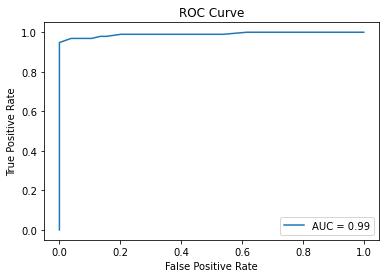

Model trained with AUC: 0.990


In [10]:
if __name__ == "__main__":
    try:
        pipeline = ExoplanetPipeline()
        
        # Example training and prediction
        if SKLEARN_AVAILABLE:
            print("Running training...")
            pipeline.run_training(synthetic_samples=1000)  # Smaller for demo
            
            # Example prediction (would need real FITS file)
            # pipeline.predict_from_fits("observation.fits")
        else:
            print("scikit-learn not available - running in data generation mode only")
            X, y = pipeline.data_gen.generate_dataset(n_samples=10)
            print("Generated sample data shapes:", X.shape, y.shape)
            
    except Exception as e:
        print(f"Error: {str(e)}", file=sys.stderr)